This animation illustrates the occurence of pairwise combinations of gene knockouts when including an increasing number of plants in a plant library. Consider a multiplex CRISPR/Cas experiment targeting pairwise combinations of gene knockouts, characterized by the experimental design parameters listed in the file "DefaultParameters_k=2.jl".

Load packages

In [9]:
using Random; Random.seed!(1234) # Set a seed for reproducibility
using Plots, StatsPlots, StatsBase
using Distributions 
using LinearAlgebra
using Combinatorics

Load default parameters and functions

In [10]:
include("MultiplexCrisprDOE.jl");
include("DefaultParameters_k=2.jl");

Function for sampling plants and recording observed pairwise combinations of gene knockouts.

In [22]:
function sampling_plants(n_plants)
    Random.seed!(1)
    
    total_combinations = length(collect(combinations(1:x, 2)))
    
    X_interactions_count = zeros(x, x) # Initialize matrix to count pairwise interactions
    
    for plant in 1:n_plants     
        # sample combinatorial gRNA/Cas9 construct
        gRNA_indices_construct = findall((rand(Multinomial(r, p_gRNA_freq))) .!= 0)
                
        # execute mutations
        gRNA_indices_mutations = [gRNA for gRNA in gRNA_indices_construct if rand(Binomial(1, p_gRNA_edit[gRNA])) == 1]
            
        # effective gene knockout (loss-of-function) ?
        gRNA_indices_KO = [gRNA for gRNA in gRNA_indices_mutations if rand(Binomial(1, ϵ_KO)) == 1]
            
        # which genes are knocked out?
        genes_indices_KO = Int.(ceil.(gRNA_indices_KO / g))
            
        # which pairwise combinations are present?
        interactions = collect(combinations(genes_indices_KO, 2))
                
        # Store represented combinations in matrix
        for interaction in interactions
            j = interaction[1]; k = interaction[2]
            
            if j != k
                if j < k 
                    X_interactions_count[j,k] += 1; 
                else 
                    X_interactions_count[k,j] += 1; 
                end
            end
        end  
    end
    
    coverage = sum(X_interactions_count .> 0)/total_combinations      
    
    return X_interactions_count, round(coverage, digits=2)
end
 

sampling_plants (generic function with 1 method)

In [27]:
function heatmap_plant_sampling(interaction_matrix, coverage, n, x)
    
    h =  heatmap(interaction_matrix,   
    c=cgrad([:white, :white,
                :turquoise1, :turquoise1, :turquoise1,
                :turquoise4, :turquoise4, :turquoise4, 
                :blue3,  :blue3, :blue3,
                :blue4, :blue4  , :blue4 , 
                :blue4  , :blue4 , :blue4, :blue4, :blue4, :blue4,  
                :darkblue, :darkblue ]),
    clim=(0,10),
    xlabel="gene knockout 1
        ", ylabel="
        gene knockout 2", 
        title="  Occurrence of pairwise combinations of gene knockouts
        [Plant library size = $n plants   -   Coverage = $coverage]
    
    ", 
        colorbar_title = "Times observed",
        colorbartitle_font = font(11, "Computer Modern"),
        colorbar_font = font(11, "Computer Modern"),
        xticks=(1:1:x, string.((1:1:x))),
        yticks=(1:1:x, string.((1:1:x))),
        titlefont=font(12,"Computer Modern"),
        xtickfont = font(10, "Computer Modern"),
         ytickfont = font(10, "Computer Modern"),
        xguidefont = font(11, "Computer Modern"),
         yguidefont = font(11, "Computer Modern"),
        size = (900,700))
    
    ann = [(i,j, text(Int(interaction_matrix'[i,j]), 8, :white, :center))
            for i in 1:x for j in 1:i-1]
    
    annotate!(ann, linecolor=:white)
    return h
    
end

heatmap_plant_sampling (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\kirst\OneDrive\Documenten\PhD\MultiplexCrisprDOE\sampling_plants.gif
└ @ Plots C:\Users\kirst\.julia\packages\Plots\YAlrZ\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\kirst\\OneDrive\\Documenten\\PhD\\MultiplexCrisprDOE\\sampling_plants.gif")
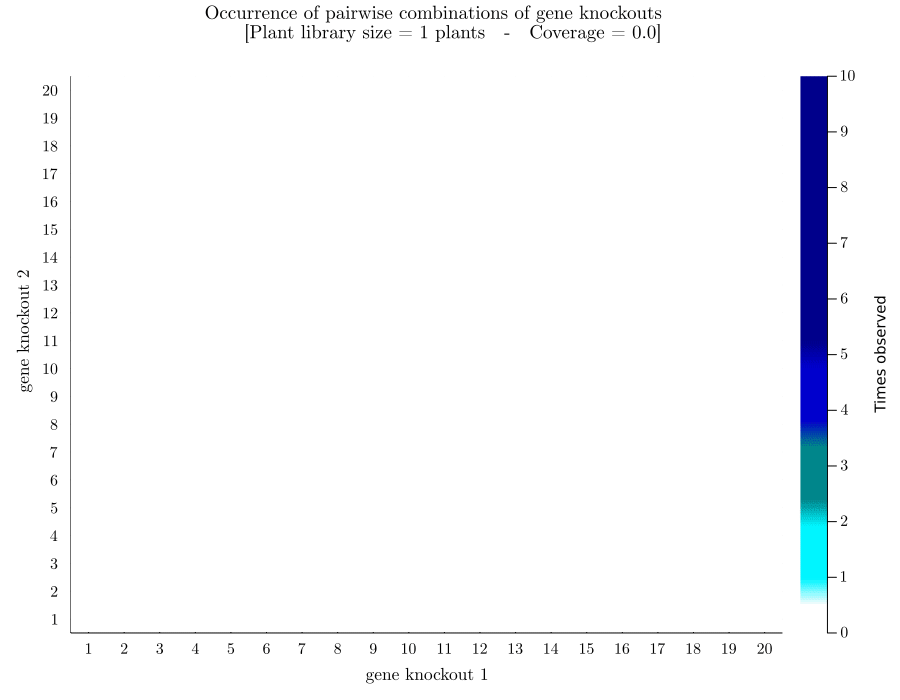

In [28]:
using Plots

collect
 
anim = @animate for n = vcat(collect(1:2:50), collect(50:5:2400))
    heatmap_plant_sampling(sampling_plants(n)[1], sampling_plants(n)[2], n, x)
end
 
gif(anim, "sampling_plants.gif", fps = 5)